# PUMP IT UP




![Image](http://drivendata.materials.s3.amazonaws.com/pumps/pumping.jpg)

Using the data gathered from Taarifa and the Tanzanian Ministry of Water, can we predict which pumps are functional, which need some repairs, and which don't work at all? Predicting one of these three classes based and a smart understanding of which waterpoints will fail, can improve the maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

This is also an intermediate-level competition by [DataDriven][1]!



[1]: https://www.drivendata.org/competitions/7/ "Link to Competetion Page"


* [Git Hub Repo](https://github.com/msampathkumar/datadriven_pumpit)
* [Git Hub Report](https://github.com/msampathkumar/datadriven_pumpit/blob/master/capstone_proposal.mdown)
* [Features Details](https://www.drivendata.org/competitions/7/page/25/)


TODO:

1. Variance Threshold Dict
2. know variance threshold for removed columns in 


# Import Libraries

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

np.random.seed(69572)

%matplotlib inline

%load_ext writeandexecute

# plt.figure(figsize=(120,10))

small = (4,3)
mid = (10, 8)
large = (12, 8)

'writeandexecute' magic loaded.


## Custom Hacks

### MarkUP Fns

In [2]:
from __future__ import absolute_import
from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)
import sys
from StringIO import StringIO
from markdown import markdown
from IPython.core.display import HTML

In [3]:
@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
    
    def timer_message(self, start_time):
        print self
        time_diff = (now() - start_time).total_seconds()
        if time_diff < 0.001:
            time_diff = 0
            print '\n<pre>In', time_diff, 'Secs</pre>'
        else:
            print '\n<pre>In', time_diff, 'Secs</pre>'

    @cell_magic
    def timer(self, line, cell):
        import datetime
        now = datetime.datetime.now
        start_time = now()
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
            self.timer_message(start_time)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

In [4]:
@magics_class
class TimeMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

### Value Counts

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

# settings
plot_col_value_count_limit = 55
x_plots_limit = 5
y_plots_limit = 5
show_percentages = True


def sam_dataframe_cols_value_count_analysis(dataframe):
    # input validations
    if type(dataframe) is not pd.core.frame.DataFrame:
        print 'dataframe is not pd.core.frame.DataFrame'
        return
    
    # preparing a list cols
    i = 1
    bag = []
    for col in dataframe.columns:
        tmp = dataframe[col].value_counts()
        if len(tmp) < plot_col_value_count_limit:
            bag.append(col)

    # subplot
    f, axarr = plt.subplots(nrows=x_plots_limit,
                            ncols=y_plots_limit,
                            squeeze=False,
                            figsize=(x_plots_limit * 4, y_plots_limit * 4))

    # subplot - col mapper
    def hack(col_name='scheme_management', ax=axarr, fontsize=6):
        ss = dataframe[col_name].value_counts()
        if show_percentages:
            ss = 100 * ss/ np.sum(ss)
        _ = ss.plot(ax=ax, kind='barh')
        ax.set_title(col_name.upper())

    # subplot - col mapping
    i = 0
    for x in range(x_plots_limit):
        for y in range(y_plots_limit):
            if i < len(bag):
                print i + 1, col, len(bag)
                col = bag[i]
                i += 1
                hack(col, axarr[x, y])
            else:
                # empty plots
                pass
            
    # Debug
    print 'Showing Plot for Columns:\n', bag

def sam_dataframe_markup_value_counts(dataframe, max_print_value_counts=30, show_plots=False, figsize=(9, 3)):
    '''
    prints value counts of each feature in data frame
    
    plots will be invidual.
    '''
    if not figsize:
        figsize=(9, 3)
    mydf = pd.DataFrame.copy(dataframe)
    i = 0
    raw_markup_data = []
    pp = raw_markup_data.append
    pp('''|Col ID|Col Name|UniqCount|Col Values|UniqValCount|''')
    pp('''|------|--------|---------|----------|------------|''')
    for col in mydf.dtypes.index:
        i += 1
        sam = mydf[col]
        sam_value_counts = sam.value_counts()
        tmp = len(sam_value_counts)
        sam_value_counts_len = len(sam_value_counts)
        if 1 < sam_value_counts_len < max_print_value_counts:
            flag = True
            for key, val in dict(sam_value_counts).iteritems():
                if flag:
                    pp('|%i|%s|%i|%s|%s|' % (
                            i, col, sam_value_counts_len, key, val))
                    flag = False
                else:
                    pp('||-|-|%s|%s|' % (key, val))
            if show_plots:
                plt.figure(i)
                ax = sam_value_counts.plot(kind='barh', figsize=figsize)
                _ = plt.title(col.upper())
                _ = plt.xlabel('counts')
        else:
            pp('|%i|%s|%i|||' % (i, col, sam_value_counts_len))
    return raw_markup_data

### Confusion Matrix

In [6]:
from __future__ import division
import itertools
from sklearn.metrics import confusion_matrix


def sam_plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

    
def sam_confusion_maxtrix(y_test, y_pred, class_names):
    '''
    Example
    >>> sam_confusion_maxtrix(y_test,
                                y_pred,
                                class_names=RAW_y.status_group.value_counts().keys()
                                ):
    '''
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8,8))
    sam_plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure(figsize=(8,8))
    sam_plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

# Load Data

In [7]:
RAW_X = pd.read_csv('traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('test_set_values.csv', index_col='id')

In [8]:
RAW_TEST_X.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,14850.000000,14850.000000,14850.000000,1.485000e+04,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,322.826983,655.147609,34.061605,-5.684724e+00,0.415084,15.139057,5.626397,184.114209,1289.708350
std,2510.968644,691.261185,6.593034,2.940803e+00,8.167910,17.191329,9.673842,469.499332,955.241087
min,0.000000,-57.000000,0.000000,-1.156459e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.069455,-8.443970e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,344.000000,34.901215,-5.049750e+00,0.000000,12.000000,3.000000,20.000000,1986.000000
75%,25.000000,1308.000000,37.196594,-3.320594e+00,0.000000,17.000000,5.000000,220.000000,2004.000000
max,200000.000000,2777.000000,40.325016,-2.000000e-08,669.000000,99.000000,80.000000,11469.000000,2013.000000


In [9]:
RAW_X.head().T

id,69572,8776,34310,67743,19728
amount_tsh,6000,0,25,0,0
date_recorded,2011-03-14,2013-03-06,2013-02-25,2013-01-28,2011-07-13
funder,Roman,Grumeti,Lottery Club,Unicef,Action In A
gps_height,1390,1399,686,263,0
installer,Roman,GRUMETI,World vision,UNICEF,Artisan
longitude,34.9381,34.6988,37.4607,38.4862,31.1308
latitude,-9.85632,-2.14747,-3.82133,-11.1553,-1.82536
wpt_name,none,Zahanati,Kwa Mahundi,Zahanati Ya Nanyumbu,Shuleni
num_private,0,0,0,0,0
basin,Lake Nyasa,Lake Victoria,Pangani,Ruvuma / Southern Coast,Lake Victoria


### cols_values_counts_dataframe

As we can see in above *describe* output, we seem to have lots of categorical values so let start exploring them a bit.

Lets start taking into believe everything is a Categorical Columns and check their data

In [10]:
columns = RAW_X.columns
values_counts_bag = [ len(RAW_X[column].value_counts()) for column in columns]

In [11]:
cols_values_counts_dataframe = pd.DataFrame(np.log(values_counts_bag), index=columns, columns=['Value Counts'])

cols_values_counts_dataframe.T

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
Value Counts,4.584967,5.874931,7.548029,7.794823,7.670895,10.959818,10.959836,10.529426,4.174387,2.197225,...,1.94591,2.079442,1.791759,1.609438,1.609438,2.302585,1.94591,1.098612,1.94591,1.791759


In [12]:
# Example of how np-log transforms data
np.log([0.001, 0.01, 0.1, 1, 10, 100, 1000])

array([-6.90775528, -4.60517019, -2.30258509,  0.        ,  2.30258509,
        4.60517019,  6.90775528])

As you can see in np-log example, we can learn that when a list of values vary significantly(exponentially) then their logarithms moves linearly. As we(I) feel comfortable in studying linear plot and linear information, we did a np.log to values counts.

Values Counts: [98, 356, 1897, 2428, 2145, 57516, 57517, 37400, 65, 9, 19287, 21, 27, 20, 125, 2092, 1049, 2, 1, 12, 2696, 2, 55, 18, 13, 7, 12, 5, 7, 7, 8, 6, 5, 5, 10, 7, 3, 7, 6]

Log of Values Counts: [  4.58496748   5.87493073   7.54802897   7.79482315   7.67089483
  10.95981845  10.95983584  10.52942598   4.17438727   2.19722458
   9.86718657   3.04452244   3.29583687   2.99573227   4.82831374
   7.64587583   6.95559261   0.69314718   0.           2.48490665
   7.89952447   0.69314718   4.00733319   2.89037176   2.56494936
   1.94591015   2.48490665   1.60943791   1.94591015   1.94591015
   2.07944154   1.79175947   1.60943791   1.60943791   2.30258509
   1.94591015   1.09861229   1.94591015   1.79175947]


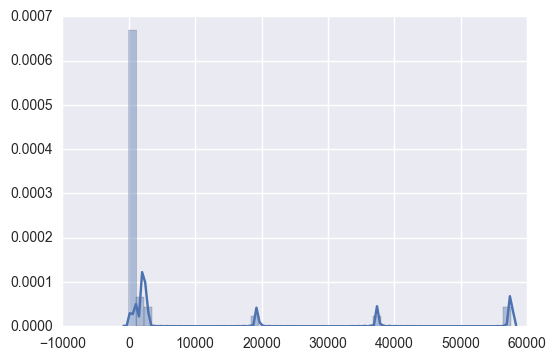

In [13]:
print 'Values Counts:', values_counts_bag

print '\nLog of Values Counts:', np.log(values_counts_bag)

_ = sns.distplot(values_counts_bag)

In [14]:
ss.plot(kind='barh', figsize=(12, 12))
_ = plt.plot((2, 2), (0, 38))
_ = plt.plot((4, 4), (0, 38), '-g')
_ = plt.plot((6, 6), (0, 38), '-r')
print 'We seem to have some special categories where value counts are high.'

NameError: name 'ss' is not defined

In [ ]:
sam_dataframe_cols_value_count_analysis(RAW_X)

** Checking Rest of other columns**

In [ ]:
cols_value_count_limit_fraction = 0.01

print 'Total Number of Records:', RAW_X.shape[0], '- Log val is:', np.log(RAW_X.shape[0])
print '%s percent of Number of Records:' % (cols_value_count_limit_fraction * 100),\
      RAW_X.shape[0] * cols_value_count_limit_fraction,\
      ' - Log val is:',  np.log(RAW_X.shape[0] * cols_value_count_limit_fraction)

Lets consider these columns with more 5% of values as non categorical values and since our problem statement is choosing which category, we will try to minimise the category and see how our performance changes(improves or not)

To begin we will consider that those categories with more than `cols_value_count_limit_fraction` percentage as the upper limit allowed. Any column with other data will pruged to become some to other information

### cols_categorical_check

In [ ]:
cols_non_categorical =   cols_values_counts_dataframe[
            cols_values_counts_dataframe.values > np.log(RAW_X.shape[0] * cols_value_count_limit_fraction)
                    ].index.tolist()

# print cols_non_categorical, len(cols_non_categorical)

# From RAW_X.head().T, we can understand following details
cols_date_numerics = 'date_recorded gps_height longitude latitude population'.split()

cols_categorical_check = [ col for col in cols_non_categorical if col not in cols_date_numerics]

print 'Columns we need to moderate are:', cols_categorical_check

All cols_date_numerics, are date & other numeric data which can be made into buckets or reducing precision. Thus we can bound number of categories in data as the more variety of data we have, we need more information specific to each category which all might end with **curse of dimensionality**.

During pre-processing states we shall do following
TODO
* limiting check experiments on our **`cols_date_numerics`** & **`cols_categorical_check`** to be under **`cols_value_count_limit_fraction`**

In [ ]:
print cols_value_count_limit_fraction * RAW_X.shape[0]

RAW_X[cols_categorical_check].head()

In [ ]:
cols_categorical_check

In [ ]:
cols_date_numerics

### logitude & latidue data check

In [ ]:
_ = sns.jointplot(x='longitude', y='longitude', data=RAW_X)

# ** Observations/TODO**

* Most of the data seems categorical
* Following pairs looks closesly related
    * quantity & quantity_group
    * quality_group & water_quality
    * extraction_type, extraction_type_class & extraction_type_group
* Other
    * recorded_by, seems to hold only a single value
    * population & amount_tsh, values are for some given as zero

Lets check those group with 

In [ ]:
# %%asmarkdown
# show me the graphs
tmp = sam_dataframe_markup_value_counts(dataframe=RAW_X, max_print_value_counts=10, show_plots=False, figsize=(9, 2))

# Pre Processing

** Num/Bool Tranformations **

* date_recorded --> Int
* longitude --> Float(less precision)
* latitude --> Float(less precision)
* public_meeting --> Bool
* permit --> Bool


Precision Description of Longititude and Latitude is available here at below link.
* http://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude

In [ ]:
from datetime import datetime
strptime = datetime.strptime

DATE_FORMAT = "%Y-%m-%d"
REFERENCE_DATE_POINT = strptime('2000-01-01', DATE_FORMAT)

# Reducing geo location precision to 11 meters
LONG_LAT_PRECISION = 0.001

def sam_datetime_to_number(x):
    return (strptime(str(x), DATE_FORMAT) - REFERENCE_DATE_POINT).days

# Splitting Date to Int
if RAW_X.date_recorded.dtype == 'O':
    RAW_X['date_recorded_year'] = RAW_X['date_recorded_year'].apply(lambda x: x.split('-')[0])
    RAW_X['date_recorded_month'] = RAW_X['date_recorded_year'].apply(lambda x: x.split('-')[1])
    RAW_X['date_recorded_date'] = RAW_X['date_recorded_year'].apply(lambda x: x.split('-')[2])

    RAW_TEST_X['date_recorded_year'] = RAW_TEST_X['date_recorded_year'].apply(lambda x: x.split('-')[0])
    RAW_TEST_X['date_recorded_month'] = RAW_TEST_X['date_recorded_year'].apply(lambda x: x.split('-')[1])
    RAW_TEST_X['date_recorded_date'] = RAW_TEST_X['date_recorded_year'].apply(lambda x: x.split('-')[2])

# Transforming Date to Int.
if RAW_X.date_recorded.dtype == 'O':
    RAW_X.date_recorded = RAW_X.date_recorded.map(sam_datetime_to_number)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.map(sam_datetime_to_number)


# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'latitude'][RAW_X.latitude < -1.0].values)
if not RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'].empty:
    RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X.latitude >= -1.0, u'latitude'] = _


# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'longitude'][RAW_X[u'longitude'] > 1.0].values)
if not RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'].empty:
    RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X[u'longitude'] <= 1.0, u'longitude'] = _


# Reducing Precision of Lat.
if RAW_X.longitude.mean() < 50:
    RAW_X.longitude = RAW_X.longitude // LONG_LAT_PRECISION
    RAW_X.latitude = RAW_X.latitude // LONG_LAT_PRECISION
    RAW_TEST_X.longitude = RAW_TEST_X.longitude // LONG_LAT_PRECISION
    RAW_TEST_X.latitude = RAW_TEST_X.latitude // LONG_LAT_PRECISION


# Fixing Missing Values
if RAW_X.public_meeting.dtype != 'bool':
    RAW_X['public_meeting_null_true'] = RAW_X.public_meeting == True
    RAW_TEST_X['public_meeting_null_true'] = RAW_TEST_X.public_meeting == True
    
    # opposite of public_meeting_null_true
    RAW_X.public_meeting = RAW_X.public_meeting == False
    RAW_TEST_X.public_meeting = RAW_TEST_X.public_meeting == False

if RAW_X.permit.dtype != 'bool':
    RAW_X['permit_null_true'] = RAW_X.permit == False
    RAW_TEST_X['permit_null_true'] = RAW_TEST_X.permit == False
    
    # opposite of permit_null_true
    RAW_X.permit = RAW_X.permit == True
    RAW_TEST_X.permit = RAW_TEST_X.permit == True

# checking
if list(RAW_TEST_X.dtypes[RAW_TEST_X.dtypes != RAW_X.dtypes]):
    raise Exception('RAW_X.dtypes and RAW_TEST_X.dtypes are not in Sync')
else:
    print 'All in Good Shape'

** Text Data Tranformations **

We are going to basic clean action like, lower and upper case issue. Clearning of non ascii values.

In [ ]:
def text_transformation(name):
    if name:
        name = name.lower().strip()
        name = ''.join([i if 96 < ord(i) < 128 else ' ' for i in name])
        if 'and' in name:
            name = name.replace('and', ' ')
        if '/' in name:
            name = name.replace('/', ' ')
        while '  ' in name:
            name = name.replace('  ', ' ')
        return name.strip()
    return

In [ ]:
%%asmarkdown

print '''
|Column|Prev.|Current|
|------|-----|-------|'''
for col in RAW_X.dtypes[RAW_X.dtypes == object].index:
    aa = len(RAW_X[col].unique())
    RAW_X[col] = RAW_X[col].fillna('').apply(text_transformation)
    RAW_TEST_X[col] = RAW_TEST_X[col].fillna('').apply(text_transformation)
    bb = len(RAW_X[col].unique())
    if aa != bb:
        print '|%s|%i|%i|' % (col, aa, bb)

## Label Encoder

Label Encoder with DefaultDict for quick data transformation
http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

In [ ]:
from collections import defaultdict
from sklearn import preprocessing

In [ ]:
d = defaultdict(preprocessing.LabelEncoder)

# Labels Fit
sam = pd.concat([RAW_X, RAW_TEST_X]).apply(lambda x: d[x.name].fit(x))

# Labels Transform - Training Data
X = RAW_X.apply(lambda x: d[x.name].transform(x))
TEST_X = RAW_TEST_X.apply(lambda x: d[x.name].transform(x))

le = preprocessing.LabelEncoder().fit(RAW_y[u'status_group'])
y = le.transform(RAW_y[u'status_group'])

In [ ]:
X.head(5)

In [ ]:
y[:5]

## Pickle

### Pickle Save

In [ ]:
pickle.dump(X, open('X.pkl', 'w'))
pickle.dump(TEST_X, open('TEST_X.pkl', 'w'))
pickle.dump(y, open('y.pkl', 'w'))
pickle.dump(d, open('d.pkl', 'w'))
pickle.dump(le, open('le.pkl', 'w'))

### Pickle Load

In [ ]:
X = pickle.load(open('X.pkl'))
y = pickle.load(open('y.pkl'))

In [ ]:
# Load this when you are about to do text transformation and submission

TEST_X = pickle.load(open('TEST_X.pkl'))
d = pickle.load(open('d.pkl'))
le = pickle.load(open('le.pkl'))

In [ ]:
X.shape, y.shape

In [ ]:
y[:5]

# Feature Selection


### Variance Threshold

To remove all features that are either one or zero (on or off) in more than 80% of the samples.

http://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance

http://stackoverflow.com/questions/29298973/removing-features-with-low-variance-scikit-learn/34850639#34850639

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def get_low_variance_columns(dframe=None, columns=[],
                             skip_columns=[], threshold=0.0,
                             autoremove=False):
    """
    Wrapper for sklearn VarianceThreshold for use on pandas dataframes.
    """
    print("Finding low-variance features.")
    removed_features = []
    ranking_variance_thresholds = {}
    try:
        # get list of all the original df columns
        all_columns = dframe.columns

        # remove `skip_columns`
        remaining_columns = all_columns.drop(skip_columns)

        # get length of new index
        max_index = len(remaining_columns) - 1

        # get indices for `skip_columns`
        skipped_idx = [all_columns.get_loc(col)
                       for col
                       in skip_columns]

        # adjust insert location by the number of columns removed
        # (for non-zero insertion locations) to keep relative
        # locations intact
        for idx, item in enumerate(skipped_idx):
            if item > max_index:
                diff = item - max_index
                skipped_idx[idx] -= diff
            if item == max_index:
                diff = item - len(skip_columns)
                skipped_idx[idx] -= diff
            if idx == 0:
                skipped_idx[idx] = item

        # get values of `skip_columns`
        skipped_values = dframe.iloc[:, skipped_idx].values

        # get dataframe values
        X = dframe.loc[:, remaining_columns].values

        # instantiate VarianceThreshold object
        vt = VarianceThreshold(threshold=threshold)

        # fit vt to data
        vt.fit(X)

        # threshold ranking
        ranking_variance_thresholds = dict(zip(remaining_columns, vt.variances_))

        # get the indices of the features that are being kept
        feature_indices = vt.get_support(indices=True)

        # remove low-variance columns from index
        feature_names = [remaining_columns[idx]
                         for idx, _
                         in enumerate(remaining_columns)
                         if idx
                         in feature_indices]

        # get the columns to be removed
        removed_features = list(np.setdiff1d(remaining_columns,
                                             feature_names))
        print("Found {0} low-variance columns."
              .format(len(removed_features)))

        # remove the columns
        if autoremove:
            print("Removing low-variance features.")
            # remove the low-variance columns
            X_removed = vt.transform(X)

            print("Reassembling the dataframe (with low-variance "
                  "features removed).")
            # re-assemble the dataframe
            dframe = pd.DataFrame(data=X_removed,
                                  columns=feature_names)

            # add back the `skip_columns`
            for idx, index in enumerate(skipped_idx):
                dframe.insert(loc=index,
                              column=skip_columns[idx],
                              value=skipped_values[:, idx])
            print("Succesfully removed low-variance columns.")

        # do not remove columns
        else:
            print("No changes have been made to the dataframe.")

    except Exception as e:
        print(e)
        print("Could not remove low-variance features. Something "
              "went wrong.")
        return dframe, [], {}

    return dframe, removed_features, ranking_variance_thresholds

In [ ]:
X, removed_features, ranking_variance_thresholds = get_low_variance_columns(dframe=X,
                                                                            threshold=(0.85 * (1 - 0.85)),
                                                                            autoremove=True)

print '\nLow Variance Columns', removed_features
print 'Shape of X is', X.shape

In [ ]:
TEST_X.drop(removed_features, axis=1, inplace=True)

In [ ]:
print 'Shape of X is', X.shape
print 'Shape of TEST_X is', TEST_X.shape

### Select K Best

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif


Random Forest Classifier score: RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1)
* chi2 0.81225589225589223
*  f_classic 0.81138047138047142
* mutual_info_classif 0.81037037037037041

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [ ]:
K_BEST_COLS = 25

fit = SelectKBest(score_func=chi2, k=K_BEST_COLS).fit(X, y)
cols_names = X.columns

np.set_printoptions(precision=2)

ranking_selectkbest = dict(zip(cols_names, fit.scores_))
selected_cols =  [_ for _ in cols_names[:K_BEST_COLS]]

features = pd.DataFrame(fit.transform(X))
features.columns = selected_cols

In [ ]:
# % pprint
ranking_selectkbest

In [ ]:
print X.shape, features.shape, len(y)

In [ ]:
print 'Removed Columns:\n\t', '\n\t'.join([ _ for _ in X.columns if _ not in features.columns ])

print '\nSelected Columns:\n\t', '\n\t'.join(features.columns)

In [ ]:
print X.shape, features.shape

In [ ]:
X = pd.DataFrame(fit.transform(X))
X.columns = selected_cols

print

# TEST_X = pd.DataFrame(fit.transform(TEST_X))
# TEST_X.columns = selected_cols

In [ ]:
TEST_X = pd.DataFrame(fit.transform(TEST_X))

print TEST_X.shape, X.shape

In [ ]:
pickle.dump(X, open('processed_X.pkl', 'w'))
pickle.dump(TEST_X, open('processed_TEST_X.pkl', 'w'))
pickle.dump(y, open('processed_y.pkl', 'w'))

### PCA

In [ ]:
X = pickle.load(open('processed_X.pkl'))
TEST_X = pickle.load(open('processed_TEST_X.pkl'))
y = pickle.load(open('processed_y.pkl'))

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# feature extraction
pca = PCA(n_components=7)
fit = pca.fit(X)

In [ ]:
plt.figure(figsize=(12, 3))

_ = plt.scatter (range(len(fit.explained_variance_ratio_)), fit.explained_variance_ratio_.cumsum())

_ = plt.xlabel('cumsum of explained variance')

print fit.explained_variance_ratio_.cumsum()

In [ ]:
X = pca.transform(X)
TEST_X = pca.transform(TEST_X)

In [ ]:
pickle.dump(X, open('processed_X.pkl', 'w'))
pickle.dump(TEST_X, open('processed_TEST_X.pkl', 'w'))
pickle.dump(y, open('processed_y.pkl', 'w'))

# Unsupervised Learning

* Unsupervised Learning Exploration(Gaussian Process, Neural Nets)

In [ ]:
X = pickle.load(open('processed_X.pkl'))
TEST_X = pickle.load(open('processed_TEST_X.pkl'))
y = pickle.load(open('processed_y.pkl'))

In [ ]:
print X.shape, y.shape, TEST_X.shape

### Gaussian

In [ ]:
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

try:
    import renders as rs
except:
    pass
import seaborn as sb
from IPython.display import display

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score

# For future analysis
GMM_Centers = []

In [ ]:
__check_for  = 1000

for i in range(2, 7):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=i, random_state=42)
    clusterer.fit(X)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(X)

    # TODO: Find the cluster centers
    GMM_Centers.append(clusterer.means_)

    # score = silhouette_score(X, preds)
    score = silhouette_score(X[:__check_for], preds[:__check_for])

    print i, score

### KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For future analysis
KMM_Centers = []

In [ ]:
# Testing each category
for i in range(2, 7):

    clusterer = KMeans(init='k-means++', n_clusters=i, n_init=10)
    clusterer.fit(X)

    preds = clusterer.predict(X)

    centers = clusterer.cluster_centers_
    
    KMM_Centers.append(centers)

#     score = silhouette_score(X, preds)
    score = silhouette_score(X[:__check_for], preds[:__check_for])
    print i, score

In [ ]:
i = 2

clusterer = KMeans(init='k-means++', n_clusters=i, n_init=10)
clusterer.fit(X)
preds = clusterer.predict(X)

In [ ]:
score = silhouette_score(X[:__check_for], preds[:__check_for])
print i, score

In [ ]:
print X.shape, TEST_X.shape

In [ ]:
X = pd.DataFrame(X)
X['new'] = clusterer.predict(X)

In [ ]:
TEST_X = pd.DataFrame(TEST_X)
TEST_X['new'] = clusterer.predict(TEST_X)

In [ ]:
print X.shape, TEST_X.shape

# Supervised Learning

* Supervised Learning(GBT Trees, Nearest Neighbours, RF, One-vs-One)

### Test-Train Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# print features.shape
# X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42, stratify=y)

### GBT Trees

In [ ]:
gbt_clf = GradientBoostingClassifier(n_estimators=150, max_depth=5)

In [ ]:
gbt_clf = gbt_clf.fit(X_train, y_train)

print 'score:', gbt_clf.score(X_test, y_test)

# score: 0.787272727273

### Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
knn_clf.fit(X_test, y_test)

In [ ]:
knn_clf.score(X_train, y_train)

### Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1)
# class_weight="balanced_subsample"/"balanced"
# criterion="gini"/"entropy"

rf_clf = rf_clf.fit(X_train, y_train)
# pred = rf_clf.predict_proba(X_test)
rf_clf.score(X_test, y_test)

# (n_estimators=100, class_weight="balanced_subsample", n_jobs=-1) 0.80782828282828278
# (n_estimators=100, class_weight="balanced_subsample", n_jobs=-1) 0.81186868686868685
# (n_estimators=150, class_weight="balanced_subsample", n_jobs=-1) 0.8113636363636364

# (n_estimators=150, criterion='gini', class_weight="balanced_subsample", n_jobs=-1) 0.81018518518518523
# (n_estimators=150, criterion='gini', class_weight="balanced", n_jobs=-1) 0.80858585858585863
# (n_estimators=150, criterion='gini', n_jobs=-1) 0.80942760942760938
# (n_estimators=150, criterion='entropy', n_jobs=-1) 0.81060606060606055

# (n_estimators=10, criterion='gini', class_weight="balanced_subsample", n_jobs=-1) 0.79781144781144786
# (n_estimators=10, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1) 0.80185185185185182
# (n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1) 0.8113636363636364
# (n_estimators=150, criterion='gini', class_weight="balanced", n_jobs=-1) 0.80984848484848482

# (n_estimators=150, criterion='gini', class_weight="balanced", n_jobs=-1) 0.81259259259259264
# (n_estimators=150, criterion='gini', class_weight="balanced_subsample", n_jobs=-1) 0.81259259259259264
# (n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1) 0.81252525252525254

# 0.81198653198653203

### One-vs-One

In [ ]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [ ]:
multiclass_rf_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200,
                                                        criterion='entropy',
                                                        class_weight="balanced_subsample",
                                                        n_jobs=-1))

# 0.81393939393939396

# 0.81272727272727274

# 0.81131313131313132

In [ ]:
multiclass_rf_clf = multiclass_rf_clf.fit(X_train, y_train)

multiclass_rf_clf.score(X_test, y_test)

In [ ]:
multiclass_rf_clf

## Parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
parameters = {
    'n_estimators': [50, 100, 150],
    'class_weight': 'balanced_subsample balanced'.split(),
    'criterion': 'gini entropy'.split()
}
GS_CV = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, n_jobs=-1)
# GS_CV = RandomizedSearchCV(RandomForestClassifier(), parameters)

GS_CV.fit(X, y)

In [ ]:
print GS_CV.best_params_, GS_CV.best_score_

In [ ]:
for each in GS_CV.grid_scores_:
    print str(each).replace(' ', '')


* Checking "rf_clf" RF performance

In [ ]:
len(rf_clf.feature_importances_)

In [ ]:
plt.figure(figsize=(12, 3))

tmp = rf_clf.feature_importances_

# making importance relative
a, b = min(tmp), max(tmp)
cols_imp = (tmp - a) /b
_ = plt.scatter(range(len(cols_imp)), cols_imp)

# line plots
_ = plt.plot((0, len(cols_imp)), (0.25, 0.25), '-g')
_ = plt.plot((0, len(cols_imp)), (0.55, 0.55), '-b')
_ = plt.plot((0, len(cols_imp)), (0.75, 0.75), '-r')

_ = plt.xlabel('Columns')
_ = plt.ylabel('Relative Col Importance')

## XGBOOST

In [ ]:
%%time

print 1

In [ ]:

# gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.05).fit(X_train, y_train)

gbm_predictions = gbm.predict(X_test)

In [ ]:
print sum(gbm_predictions == y_test)/ (1.0 * len(y_test)) # 0.7279461279461279

# Submission

In [ ]:
test_ids = RAW_TEST_X.index

predictions = clf.predict(TEST_X)

print (predictions.shape)

predictions_labels = le.inverse_transform(predictions)

# sub = pd.DataFrame(predictions, columns=list(le.classes_))
sub = pd.DataFrame(predictions_labels, columns=['status_group'])
sub.head()

sub.insert(loc=0, column='id', value=test_ids)
sub.reset_index()
sub.to_csv('submit.csv', index = False)
sub.head()